### See https://github.com/aleju/imgaug and http://imgaug.readthedocs.io/en/latest/index.html

In [8]:
import imgaug
from imgaug import augmenters as iaa
import numpy as np
import glob
import imageio
import os

In [9]:
input_directory = '/data/vein/augmentor/input'
image_file_list = glob.glob("{}/images/*.png".format(input_directory))
mask_file_list = glob.glob("{}/masks/*.png".format(input_directory))

In [10]:
AUGMENTED_IMAGES_PER_ORIGINAL = 1
IMAGE_EDGE_LENGTH = 1300
NUMBER_OF_IMAGE_CHANNELS = 3
NUMBER_OF_MASK_CHANNELS = 1

output_dir = '/data/augmented-vein-data/7-jun'
augmented_images_directory = "{}/images".format(output_dir)
augmented_masks_directory = "{}/masks".format(output_dir)

# remove all previous augmentations
import shutil
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# create a new directory structure
os.makedirs(augmented_images_directory)
os.makedirs(augmented_masks_directory)        

In [11]:
affine_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-120, 120)) # rotate images between -120 and +120 degrees
], random_order=True)

In [12]:
colour_seq = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5), # normalize contrast by a factor of 0.5 to 1.5, sampled randomly per image and for 50% of all images also independently per channel
    iaa.Multiply((0.5, 1.5), per_channel=0.5), # multiply 50% of all images with a random value between 0.5 and 1.5 and multiply the remaining 50% channel-wise, i.e. sample one multiplier independently per channel
    iaa.Add((-40, 40), per_channel=0.5) # add random values between -40 and 40 to images. In 50% of all images the values differ per channel (3 sampled value). In the other 50% of all images the value is the same for all channels
], random_order=True)

In [91]:
# go through all the images and create a set of augmented images and masks for each
for idx in range(len(image_file_list)):
    augmented_images = []
    augmented_masks = []

    base_name = os.path.basename(image_file_list[idx])

    base_image = imageio.imread(image_file_list[idx])
    base_mask = imageio.imread(mask_file_list[idx])

    # make sure all the images and masks are the same shape
    if base_image.shape[1] != IMAGE_EDGE_LENGTH:
        new_base_image = np.zeros((IMAGE_EDGE_LENGTH, IMAGE_EDGE_LENGTH, NUMBER_OF_IMAGE_CHANNELS), dtype=np.uint8)
        new_base_image[:base_image.shape[0],:base_image.shape[1],:base_image.shape[2]] = base_image
        base_image = new_base_image

        # from the imgaug doco: "grayscale images must have shape (height, width, 1) each."
        new_base_mask = np.zeros((IMAGE_EDGE_LENGTH, IMAGE_EDGE_LENGTH, NUMBER_OF_MASK_CHANNELS), dtype=np.uint8)
        new_base_mask[:base_mask.shape[0],:base_mask.shape[1],0] = base_mask
        base_mask = new_base_mask
    else:
        base_mask.shape = (IMAGE_EDGE_LENGTH, IMAGE_EDGE_LENGTH, 1)
    
    images_list = []
    masks_list = []
    for i in range(AUGMENTED_IMAGES_PER_ORIGINAL):
        images_list.append(base_image)
        masks_list.append(base_mask)
        
    # convert the image lists to an array of images as expected by imgaug
    images = np.stack(images_list, axis=0)
    masks = np.stack(masks_list, axis=0)

    # Convert the stochastic sequence of augmenters to a deterministic one.
    # The deterministic sequence will always apply the exactly same effects to the images.
    affine_det = affine_seq.to_deterministic() # call this for each batch again, NOT only once at the start

    images_aug = affine_det.augment_images(images)
    masks_aug = affine_det.augment_images(masks)
    
    # apply the colour augmentations to the images but not the masks
    images_aug = colour_seq.augment_images(images_aug)
    
    # write out the un-augmented image/mask pair
    output_base_name = "{}_orig{}".format(os.path.splitext(base_name)[0], os.path.splitext(base_name)[1])
    imageio.imwrite("{}/{}".format(augmented_images_directory,output_base_name), base_image)
    imageio.imwrite("{}/{}".format(augmented_masks_directory,output_base_name), base_mask)
    
    # now write out the augmented image/mask pairs
    for i in range(AUGMENTED_IMAGES_PER_ORIGINAL):
        output_base_name = "{}_augm_{}{}".format(os.path.splitext(base_name)[0], i, os.path.splitext(base_name)[1])
        imageio.imwrite("{}/{}".format(augmented_images_directory,output_base_name), images_aug[i])
        imageio.imwrite("{}/{}".format(augmented_masks_directory,output_base_name), masks_aug[i])


adding padding to UE210_0076_01.png.0.png_cropped_16.png
adding padding to UE118_0091_02.png.0.png_cropped_15.png
adding padding to UE210_0064_02.png.2.png_cropped_16.png
adding padding to UE219_0114_02.png.5.png_cropped_15.png
adding padding to UE210_0119_02.png.5.png_cropped_16.png
adding padding to UE219_0115_03.png.6.png_cropped_15.png
adding padding to NC548_0412_03.png.9.png_cropped_15.png
adding padding to UE210_0119_02.png.4.png_cropped_16.png
adding padding to NC548_0393_00.png.3.png_cropped_15.png
adding padding to UE210_0119_02.png.7.png_cropped_16.png
adding padding to UE118_0100_02.png.7.png_cropped_15.png
adding padding to UE219_0092_01.png.0.png_cropped_15.png
adding padding to UE210_0119_01.png.0.png_cropped_16.png
adding padding to NC548_0334_03.png.1.png_cropped_15.png
adding padding to UE210_0042_03.png.3.png_cropped_16.png
adding padding to UE219_0115_01.png.4.png_cropped_15.png
adding padding to NC548_0412_03.png.5.png_cropped_15.png
adding padding to NC548_0239_03

KeyboardInterrupt: 

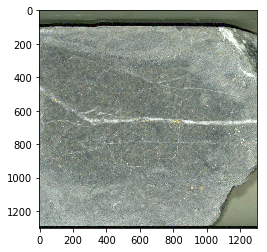

In [81]:
import matplotlib.pyplot as plt
image = imageio.imread('/data/daryl-data/augment-test/images/UE210_0064_01.png.4.png_cropped_14_orig.png')
_ = plt.imshow(image)

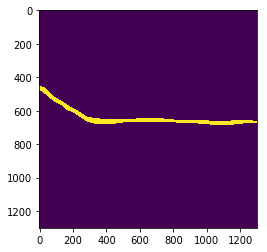

In [82]:
image = imageio.imread('/data/daryl-data/augment-test/masks/UE210_0064_01.png.4.png_cropped_14_orig.png')
_ = plt.imshow(image)

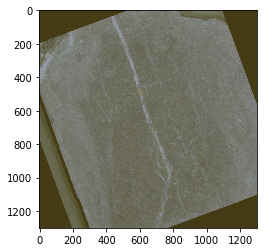

In [83]:
import matplotlib.pyplot as plt
image = imageio.imread('/data/daryl-data/augment-test/images/UE210_0064_01.png.4.png_cropped_14_augm_0.png')
_ = plt.imshow(image)

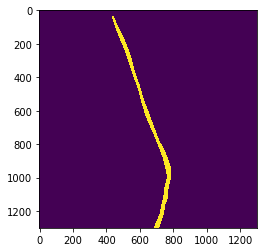

In [84]:
import matplotlib.pyplot as plt
image = imageio.imread('/data/daryl-data/augment-test/masks/UE210_0064_01.png.4.png_cropped_14_augm_0.png')
_ = plt.imshow(image)